# Perceptron Lab





In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import Perceptron
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import arff
from random import randint
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tabulate import tabulate

## 1. (40%) Correctly implement and submit your own code for the perceptron learning algorithm. 

### Code requirements
- Shuffle the data each epoch.
- A way to create a random train/test split. Write your own. In the future you can use the scikit-learn version if you want.
- Use Stochastic/On-line training updates: Iterate and update weights after each training instance (i.e. do not attempt batch updates)
- Implement a stopping criteria: when your model has trained for a number of epochs with no significant improvement in accuracy, stop training. Note that the weights/accuracy do not usually change monotonically.
- Use your perceptron to solve the Debug data. We provide you with several parameters, and you should be able to replicate our results every time. When you are confident it is correct, run your perceptron on the Evaluation data with the same parameters, and print your final weights and accuracy.

In [ ]:
class PerceptronClassifier(BaseEstimator,ClassifierMixin):

    def __init__(self, lr=.1, shuffle=True):
        """ 
            Initialize class with chosen hyperparameters.
        Args:
            lr (float): A learning rate / step size.
            shuffle: Whether to shuffle the training data each epoch. DO NOT 
            SHUFFLE for evaluation / debug datasets.
        """
        self.lr = lr
        self.shuffle = shuffle

    def fit(self, X, y, epochs=None, initial_weights=None):
        """ 
            Fit the data; run the algorithm and adjust the weights to find a 
            good solution
        Args:
            X (array-like): A 2D numpy array with the training data, excluding
            targets
            y (array-like): A 2D numpy array with the training targets
            initial_weights (array-like): allows the user to provide initial 
            weights
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        self.X, self.y = X, y
        self.weights = self.initialize_weights() if not initial_weights else initial_weights
        self.epoch_count = 0
        self.epoch_data = []

        if epochs:
            for _ in range(epochs):
                self.epoch_data.append(self.run_epoch())
                self.epoch_count += 1
        else:
            error_rate_change = 1
            while error_rate_change > 0.001 and self.epoch_count < 50:
                run1 = self.run_epoch()
                run2 = self.run_epoch()
                self.epoch_data.append(run1)
                self.epoch_data.append(run2)
                error_rate_change = abs(run1 - run2)
                self.epoch_count += 2

        return self
    
    def run_epoch(self):
        # Check to shuffle
        if self.shuffle:
            self.X, self.y = self._shuffle_data(self.X, self.y)
        
        err_count = 0
        # Run perceptron over data (1 epoch)
        for i, x in enumerate(self.X):
            pattern = np.append(x, 1)
            t = self.y[i, 0]
            z = 1 if np.dot(pattern, self.weights) > 0 else 0
            if t != z:
                err_count += 1
            self.weights += self.lr * (t - z) * pattern
        return err_count / len(self.X)

    def predict(self, X):
        """ 
            Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding 
            targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        net = lambda x: np.dot(np.append(x, 1), self.weights)
        return np.array([1 if net(x) > 0 else 0 for x in X])

    def initialize_weights(self):
        """ Initialize weights for perceptron. Don't forget the bias!
        Returns:
        """
        return [0 for _ in range(len(self.X[0]) + 1)]

    def score(self, X, y):
        """ 
            Return accuracy of model on a given dataset. Must implement own 
            score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        total = sum([1 for i, z in enumerate(self.predict(X)) if z == y[i]])
        return total / len(X)

    def _shuffle_data(self, X, y):
        """ 
            Shuffle the data! This _ prefix suggests that this method should 
            only be called internally.
            It might be easier to concatenate X & y and shuffle a single 2D 
            array, rather than shuffling X and y exactly the same way, 
            independently.
        """
        data = np.hstack((X, y))
        # fisher-yates
        for i in range(len(data)-1, 0, -1):
            j = randint(0, i)
            data[[i, j]] = data[[j, i]]
        return (data[:, :-1], np.array([data[:, -1]]).T)


    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        return [round(w, 2) for w in self.weights]

## 1.1 Debug and Evaluation

Debug and Evaluate your model using the parameters below

Learning Rate = 0.1 \ 
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it] \ 
Shuffle = False \ 
Initial Weights = All zeros

---

### 1.1.1 Debug

Debug your model by running it on the [debug dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff)

Expected Results:

Accuracy = [0.88]\
Final Weights = [-0.23  0.18 -0.1 ]

In [ ]:
# Load debug data (add "&> /dev/null" to hide output)
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff --output linsep2nonorigin.arff &> /dev/null

# Train on debug data
debug_data = arff.loadarff('linsep2nonorigin.arff')
debug_np = np.array(debug_data[0].tolist(), dtype=np.float64)
debug_x = debug_np[:, :-1]
debug_y = np.array([debug_np[:, -1]]).T
debug_perceptron = PerceptronClassifier(shuffle=False)
debug_perceptron.fit(debug_x, debug_y, epochs=10)

# Print accuracy and weights
print("Accuracy:", debug_perceptron.score(debug_x, debug_y))
print("Final Weights: ", debug_perceptron.get_weights())

Accuracy: 0.875
Final Weights:  [-0.23, 0.18, -0.1]


### 1.1.2 Evaluation

We will evaluate your model based on it's performance on the [evaluation dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff)

In [ ]:
def shuffle(data):
    # fisher-yates
    for i in range(len(data)-1, 0, -1):
        j = randint(0, i)
        data[[i, j]] = data[[j, i]]
    return data

In [ ]:
# Load evaluation data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff --output data_banknote_authentication.arff &> /dev/null

# Train on evaluation data
eval_data = arff.loadarff('data_banknote_authentication.arff')
eval_np = np.array(eval_data[0].tolist(), dtype=np.float64)
eval_shuffled = shuffle(eval_np)
split_num = round(len(eval_shuffled) * 0.75)
# Split into training and testing
eval_train, eval_test = eval_shuffled[:split_num], eval_shuffled[split_num:]
eval_train_x, eval_train_y = eval_train[:, :-1], np.array([eval_train[:, -1]]).T
eval_test_x, eval_test_y = eval_test[:, :-1], np.array([eval_test[:, -1]]).T
eval_percptron = PerceptronClassifier(lr=0.01)
eval_percptron.fit(eval_train_x, eval_train_y)

# Print accuracy and weights
print("Accuracy:", eval_percptron.score(eval_test_x, eval_test_y))
print("Final Weights:", eval_percptron.get_weights())

Accuracy: 0.9854227405247813
Final Weights: [-0.71, -0.38, -0.44, -0.14, 0.71]


## 2. (30%) Classifying on linearly separable and non-linearly separable data

### 2.1 Create 2 datasets

- Both with 8 instances using 2 real valued inputs (ranging between -1 and 1) with 4 instances from each class. 
- One data set should be linearly separable and the other not.



In [ ]:
# Create 2 datasets
sep = np.array([[-0.71,0.69,0],[-0.28,0.26,0],[-0.74,-0.16,0],[0.06,-0.74,0],[-0.21,0.66,1],[-0.09,0.6,1],[-0.01,0.77,1],[0.21,0.52,1]])
nonsep = np.array([[-0.39,0.4,0],[-0.26,0.24,0],[-0.14,0.09,0],[-0.02,-0.06,0],[-0.47,-0.08,1],[-0.32,0.05,1],[-0.01,0.31,1],[0.15,0.44,1]])

### 2.2 Train on both sets with your perceptron code (with LR=.1)

In [ ]:
# Train on each dataset
sep_percept = PerceptronClassifier()
sep_percept.fit(sep[:, :-1], np.array([sep[:, -1]]).T, epochs=10)
sep_weights = sep_percept.get_weights()

nonsep_percept = PerceptronClassifier()
nonsep_percept.fit(nonsep[:, :-1], np.array([nonsep[:, -1]]).T)
nonsep_weights = nonsep_percept.get_weights()

### 2.3 Graph the datasets and their corresponding decision line
 
 - Graph each dataset
 - Use your trained perceptrons above to determine each dataset's decision line
 - For all graphs always label the axes!
 
![Linearly Separable Data](https://raw.githubusercontent.com/rmorain/CS472-1/master/images/perceptron/linearly_separable.png)

![Not Linearly Separable](https://raw.githubusercontent.com/rmorain/CS472-1/master/images/perceptron/not_linearly_separable.png)

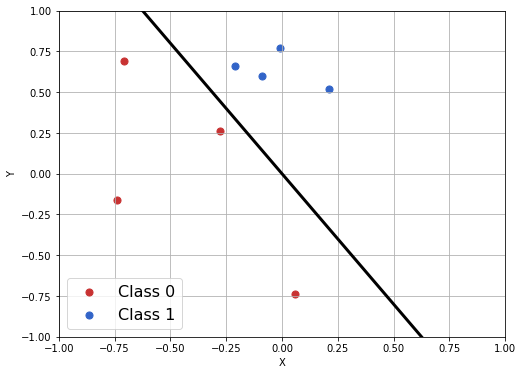

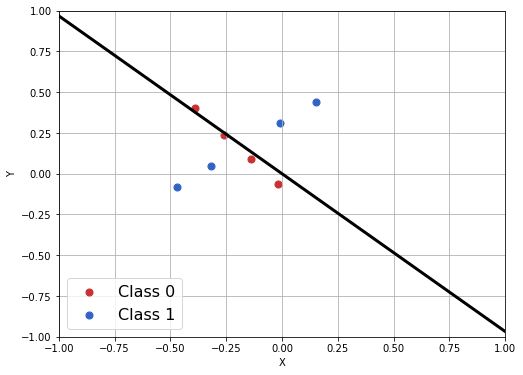

In [ ]:
# Graph datasets and decision lines

# Linear seperable data
plt.figure(figsize=(8, 6))
c0 = np.array([p for p in sep if p[-1] == 0])
c1 = np.array([p for p in sep if p[-1] == 1])
plt.scatter(c0[:,0], c0[:,1], c='#c83232', s=50, label="Class 0")
plt.scatter(c1[:,0], c1[:,1], c='#3264c8', s=50, label="Class 1")
plt.legend(loc="lower left", prop={'size': 16})
lx = np.array([-1, 1])
ly = (-sep_weights[0] / sep_weights[1]) * lx + (sep_weights[2] / sep_weights[1])
plt.plot(lx, ly, c='k', lw=3)
plt.xlabel('X')
plt.ylabel('Y')
plt.axis([-1, 1, -1, 1])
plt.grid()
plt.show()

# Non-linear seperable data
plt.figure(figsize=(8, 6))
c0 = np.array([p for p in nonsep if p[-1] == 0])
c1 = np.array([p for p in nonsep if p[-1] == 1])
plt.scatter(c0[:,0], c0[:,1], c='#c83232', s=50, label="Class 0")
plt.scatter(c1[:,0], c1[:,1], c='#3264c8', s=50, label="Class 1")
plt.legend(loc="lower left", prop={'size': 16})
lx = np.array([-1, 1])
nonsep_weights[1] += 0.001
ly = (-nonsep_weights[0] / nonsep_weights[1]) * lx + (nonsep_weights[2] / nonsep_weights[1])
plt.plot(lx, ly, c='k', lw=3)
plt.axis([-1, 1, -1, 1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

### 2.4 Discuss why the perceptron won’t converge on non-linearly separable data.

It doesn't converge because the perception - via it's weights - attepts to find a hyperplane to sperate the data. Thus, on the data that is not linearly seperable, it will continue updating trying to find what it never will.

## 3. (20%) Use your perceptron code to learn this version of the [voting data set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting-dataset.arff).

This particular task is an edited version of the standard voting set, where we have replaced all the “don’t know” values with the most common value for the particular attribute.  

### 3.1 Create a table that reports the final training and test set accuracy and the number of epochs for each trial.

- Try it five times with different random 70/30 splits. 
- Use your own code to randomize and make splits. 
- Report the 5 trials and the average across the 5 trials in a table.  

| Trial | Training Accuracy | Test accuracy | Number of epochs |
| --- | --- | --- | --- |
| 1 | .95 | .55 | 4 |
| 2 | .85 | .45 | 6 |
| Average | .9 | .5 | 5 | 

*- As a rough sanity check, typical Perceptron test accuracies for the voting data set are 90%-98%.*


In [ ]:
# Create the table any way you like
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting-dataset.arff --output voting-dataset.arff &> /dev/null
# Train on voting data
voting_data = arff.loadarff('voting-dataset.arff')
voting_np = pd.DataFrame(voting_data[0]).apply(LabelEncoder().fit_transform).to_numpy().astype(float)

weights = []
trials = []
epoch_accuracy = []
for i in range(5):
    voting_shuffled = shuffle(voting_np)
    split_num = round(len(voting_shuffled) * 0.70)
    # Split into training and testing
    voting_train, voting_test = voting_shuffled[:split_num], voting_shuffled[split_num:]
    voting_train_x, voting_train_y = voting_train[:, :-1], np.array([voting_train[:, -1]]).T
    voting_test_x, voting_test_y = voting_test[:, :-1], np.array([voting_test[:, -1]]).T
    voting_percptron = PerceptronClassifier(lr=0.01)
    voting_percptron.fit(voting_train_x, voting_train_y)
    weights.append(voting_percptron.get_weights())
    epoch_accuracy.append(voting_percptron.epoch_data)
    train_accuracy = voting_percptron.score(voting_train_x, voting_train_y)
    test_accuracy = voting_percptron.score(voting_test_x, voting_test_y)
    trials.append([i+1, round(train_accuracy, 2), round(test_accuracy, 2), voting_percptron.epoch_count])

average_train_accuracy = round(sum([row[1] for row in trials]) / 5, 2)
average_test_accuracy = round(sum([row[2] for row in trials]) / 5, 2)
average_epochs = round(sum([row[3] for row in trials]) / 5)
trials.append(["Average", average_train_accuracy, average_test_accuracy, average_epochs])
print(tabulate(trials, headers=["Trial", "Training Accuracy", "Test Accuracy", "# of Epochs"]))

Trial      Training Accuracy    Test Accuracy    # of Epochs
-------  -------------------  ---------------  -------------
1                       0.98             0.94             46
2                       0.97             0.93              8
3                       0.97             0.95             50
4                       0.95             0.95             30
5                       0.84             0.8              14
Average                 0.94             0.91             30


In [ ]:
avg_weights = np.array(weights[0])
for weight in weights[1:]:
    avg_weights += weight
print([round(w, 2) for w in avg_weights])

[0.01, -0.15, -0.34, 0.87, 0.16, -0.11, 0.24, 0.26, -0.4, 0.18, -0.39, 0.04, 0.03, -0.0, -0.26, 0.1, -0.63]


### 3.2 By looking at the weights, explain what the model has learned and how the individual input features affect the result. Which specific features are most critical for the voting task, and which are least critical? 


Things like water-project-cost-sharing, adoption-of-the-budget-resolution, and immigration are important to the learning while education-spending, and superfund-right-to-sue are not.

### 3.3 Make a graph of the average misclassification rate vs epochs (0th – final epoch).

- Average the misclassification rate for the training set across your 5 trials (not across 5 epochs).


![Average Misclassification Rate](https://raw.githubusercontent.com/rmorain/CS472-1/master/images/perceptron/avg_misclassification_rate_vs_epochs.png)

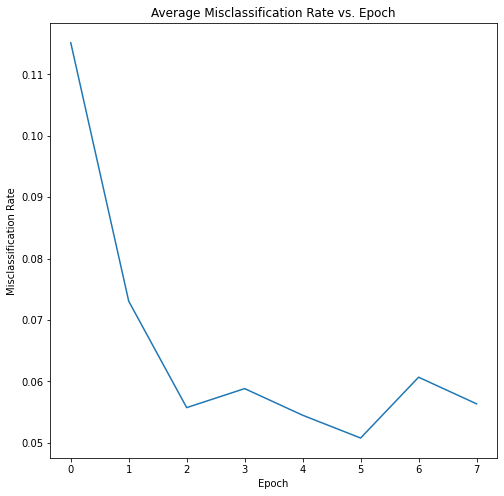

In [ ]:
# Graph here
    
def plot_misclassification(avg_misclassification_rate):
    """
        Plots the average misclassification rate
    Args:
        avg_misclassification_rate (array-like): A 1D array or list
    """        
    plt.plot(np.arange(len(avg_misclassification_rate)), avg_misclassification_rate)
    plt.title("Average Misclassification Rate vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Misclassification Rate")
    plt.show()

shortest = 50
for run in epoch_accuracy:
    l = len(run)
    if l < shortest:
        shortest = l
        
avg_misclassification_rate = []
for i in range(shortest):
    total = 0
    for run in epoch_accuracy:
        total += run[i]
    avg_misclassification_rate.append(total / 5)
plot_misclassification(avg_misclassification_rate)

## 4.1 (5%) Use the perceptron algorithm from the [scikit-learn toolkit](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) to learn the voting task above.
- Report and compare your results with your own perceptron code.

In [ ]:
# Load sklearn perceptron

# Train on voting dataset

*Report your comparison*

## 4.2 (5%) Use the perceptron algorithm from the [scikit-learn toolkit](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) to learn one other data set of your choice.
- Try out some of the hyper-parameters that scikit-learn makes available.

In [ ]:
# Load sklearn perceptron

# Train on your dataset

*Report what hyperparameters you experimented with & what performed well*

## 5. (Optional 5% extra credit) Use the perceptron rule to learn the [iris task](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff) or some other task with more than two possible output values. 

Note that the [iris data](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff) set has 3 output classes, and a perceptron node only has two possible outputs.  You could implement either of the two most common ways to deal with this. For testing you just execute the novel instance on each model and combine the overall results to see which output class wins.